# Workflow

In [1]:
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
import numpy as np
import pandas as pd

import mammos_analysis
import mammos_dft
import mammos_spindynamics
import mammos_mumag
import mammos_entity as me
import mammos_units as u

u.set_enabled_equivalencies(u.magnetic_flux_field());

In [2]:
%config InlineBackend.figure_format = "retina"

## 1: DFT data: magnetisation and anisotropy at zero Kelvin

In [3]:
results_dft = mammos_dft.db.get_micromagnetic_properties("Nd2Fe14B-136", print_info=True)

Found material in database.

Chemical Formula: Nd2Fe14B
Space group name: P42/mnm
Space group number: 136
Cell length a: 8.78 Angstrom
Cell length b: 8.78 Angstrom
Cell length c: 12.12 Angstrom
Cell angle alpha: 90.0 deg
Cell angle beta: 90.0 deg
Cell angle gamma: 90.0 deg
Cell volume: 933.42 Angstrom
ICSD_label: 
OQMD_label:

The first step loads spontaneous magnetisation $M_s$ and the uniaxial anisotropy constant $K_1$ from a database of DFT calculations.

In [4]:
results_dft

MicromagneticProperties(Ms_0=SpontaneousMagnetization(value=1280000.0, unit=A / m), K1_0=UniaxialAnisotropyConstant(value=4300000.0, unit=J / m3))

In [5]:
results_dft.Ms_0

SpontaneousMagnetization(value=1280000.0, unit=A / m)

In [6]:
results_dft.K1_0

UniaxialAnisotropyConstant(value=4300000.0, unit=J / m3)

## 2: Temperature-dependent magnetisation data from spindynamics database lookup

In [7]:
results_spindynamics = mammos_spindynamics.db.get_spontaneous_magnetisation("Nd2Fe14B-136")

In the second step we use a spin dynamics calculation database. We load some points for the temperature-dependent magnetisation.

In [8]:
results_spindynamics.T

ThermodynamicTemperature(value=
[  0.          31.57894737  63.15789474  94.73684211 126.31578947
 157.89473684 189.47368421 221.05263158 252.63157895 284.21052632
 315.78947368 347.36842105 378.94736842 410.52631579 442.10526316
 473.68421053 505.26315789 536.84210526 568.42105263 600.
 630.         690.         720.         750.         780.        ],
 unit=K)

In [9]:
results_spindynamics.Ms

SpontaneousMagnetization(value=
[1460000.         1456985.36046193 1449449.93657199 1437972.77253639
 1422736.58364638 1403779.39648225 1381044.11152378 1354391.97626968
 1323600.99407897 1288353.67899904 1248213.31769096 1202584.11677895
 1150645.20320241 1091237.80552561 1022660.54963577  942263.95974459
  845538.33920183  723617.755767    553555.21471405  171781.14820705
       0.               0.               0.               0.
       0.        ],
 unit=A / m)

In [10]:
results_spindynamics.dataframe.head()

,T,Ms
0,0.000000,1.460000e+06
1,31.578947,1.456985e+06
2,63.157895,1.449450e+06
3,94.736842,1.437973e+06
4,126.315789,1.422737e+06


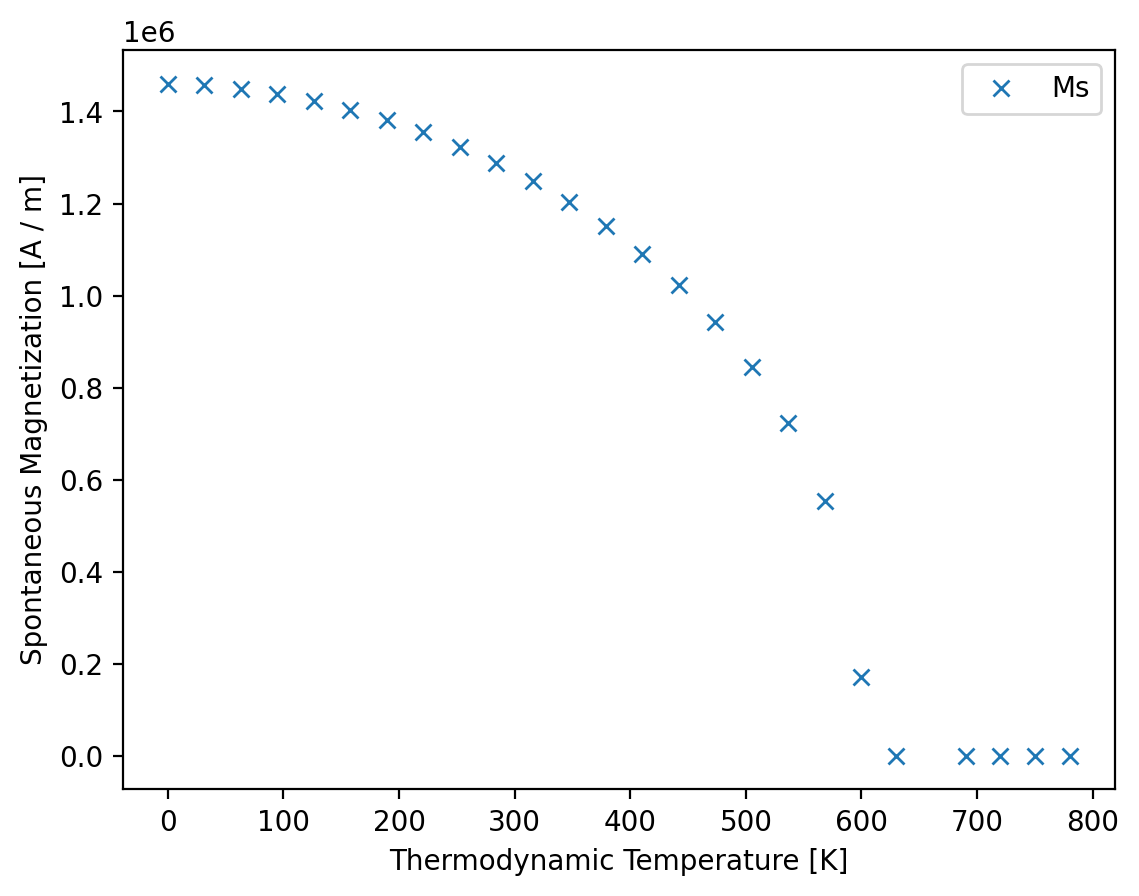

In [11]:
results_spindynamics.plot();

## 3: Calculate micromagnetic intrinsic properties using Kuz'min formula

In [12]:
kuzmin_result = mammos_analysis.kuzmin_properties(
    T=results_spindynamics.T,
    Ms=results_spindynamics.Ms,
    K1_0=results_dft.K1_0,
)

In [13]:
kuzmin_result

KuzminResult(Ms=Ms(T), A=A(T), K1=K1(T), Tc=ThermodynamicTemperature(value=587.7781199945, unit=K), s=<Quantity 0.96482643>)

In [14]:
kuzmin_result.Tc

ThermodynamicTemperature(value=587.7781199945, unit=K)

In [15]:
kuzmin_result.s

<Quantity 0.96482643>

In [16]:
kuzmin_result.Ms

Ms(T)

In [17]:
kuzmin_result.A

A(T)

In [18]:
kuzmin_result.K1

K1(T)

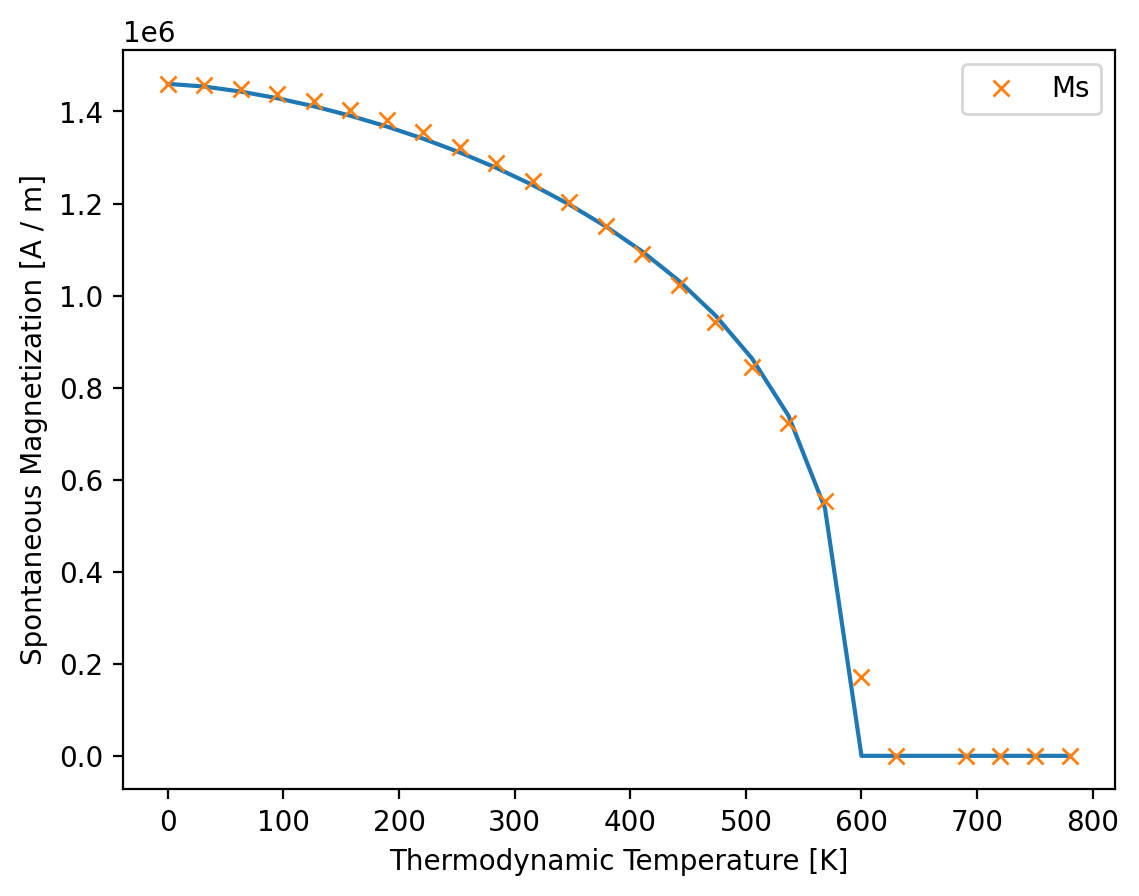

In [19]:
ax = kuzmin_result.Ms.plot()
results_spindynamics.plot(ax=ax);  # change kuzmin to not raise a warning for T>Tc

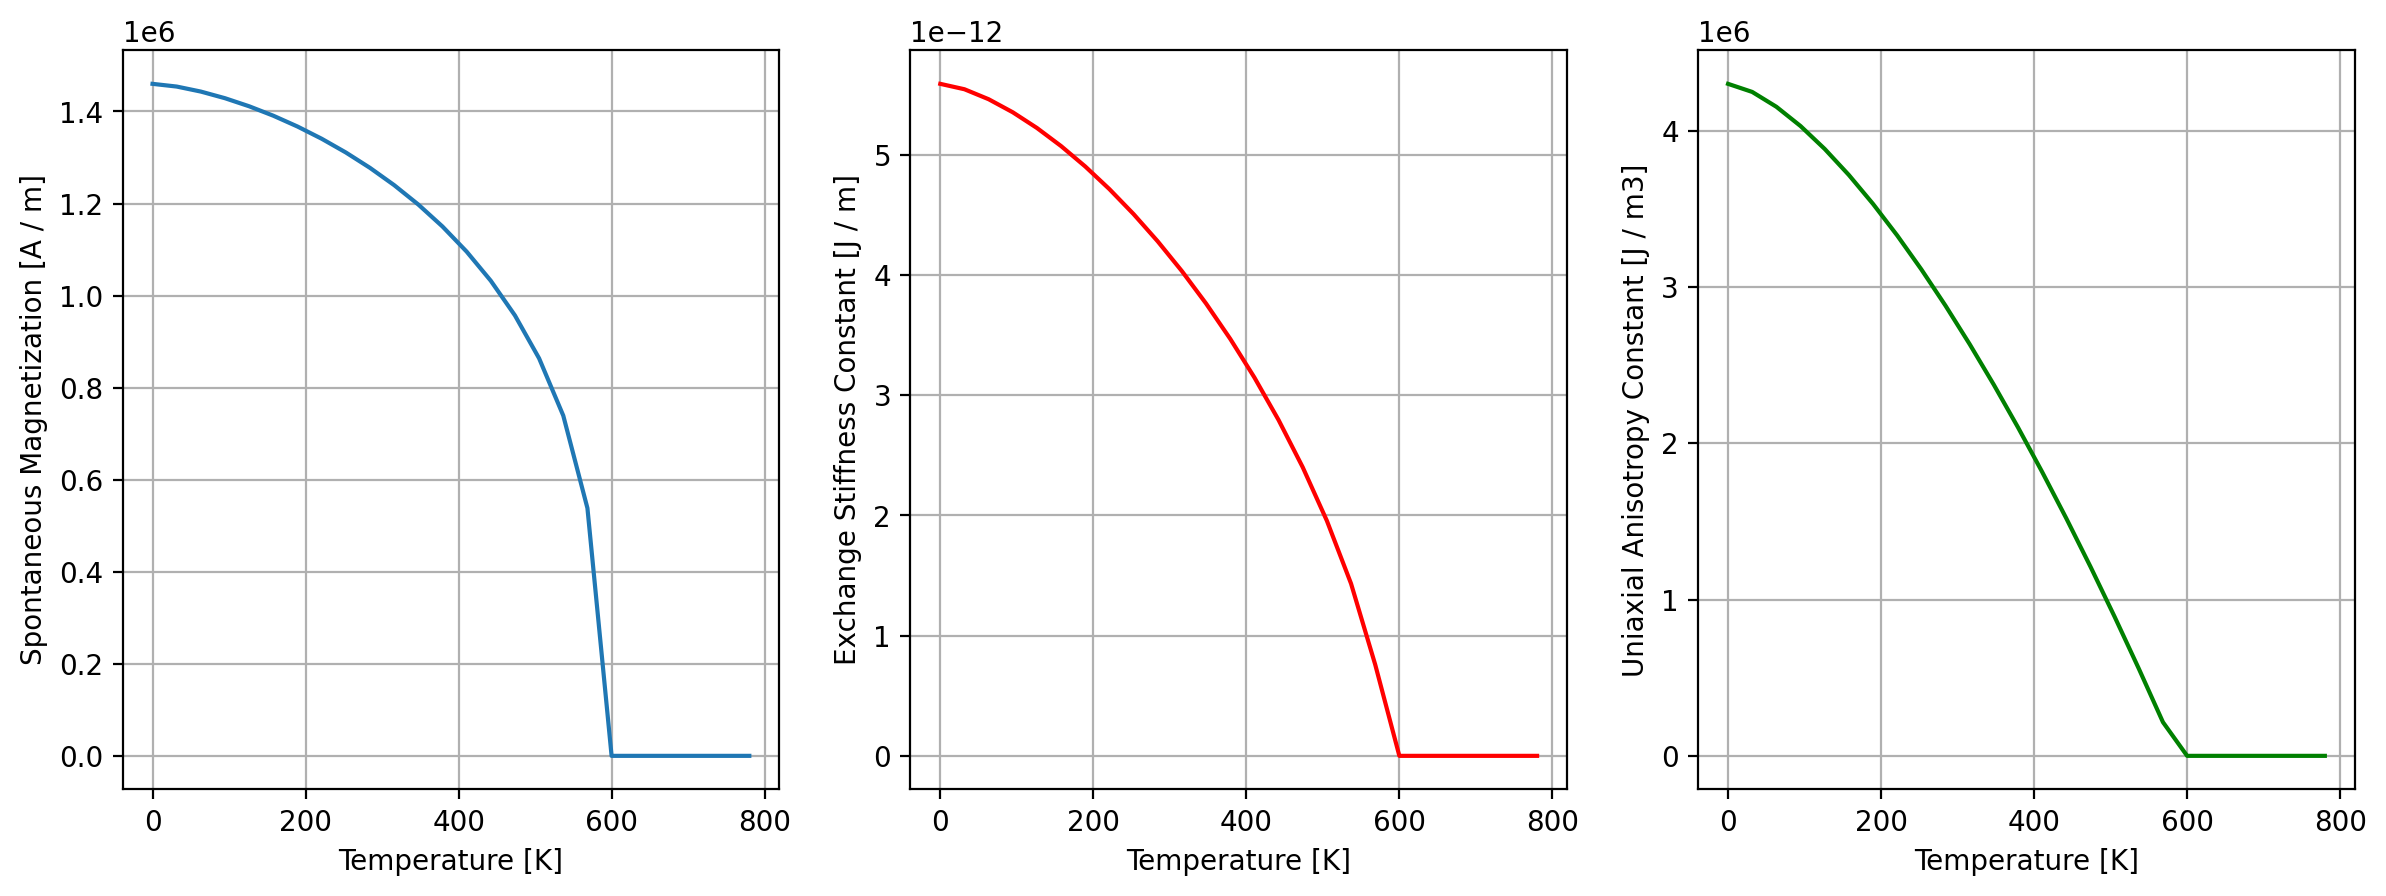

In [20]:
kuzmin_result.plot();

In [21]:
temperature = me.Entity("ThermodynamicTemperature", value=300, unit="K")
temperature

ThermodynamicTemperature(value=300.0, unit=K)

In [22]:
kuzmin_result.Ms(temperature)

SpontaneousMagnetization(value=1259264.6948938747, unit=A / m)

In [23]:
kuzmin_result.A(temperature)

ExchangeStiffnessConstant(value=4.158634560345106e-12, unit=J / m)

In [24]:
kuzmin_result.K1(temperature)

UniaxialAnisotropyConstant(value=2759058.89344602, unit=J / m3)

## 4: Run micromagnetic simulation – Evaluate hysteresis loop

In [25]:
loop_results = mammos_mumag.hysteresis.run(
    mesh_filepath=mammos_mumag.mesh.CUBE_20_nm,
    Ms=kuzmin_result.Ms(temperature),
    A=kuzmin_result.A(temperature),
    K1=kuzmin_result.K1(temperature),
    hstart=(7*u.T).to(u.A / u.m),
    hfinal=(-7*u.T).to(u.A / u.m),
    hnsteps=30,
)

In [26]:
loop_results.H

ExternalMagneticField(value=
[ 5.57042301e+06  5.19906147e+06  4.82769994e+06  4.45633840e+06
  4.08497687e+06  3.71361534e+06  3.34225380e+06  2.97089227e+06
  2.59953074e+06  2.22816920e+06  1.85680767e+06  1.48544613e+06
  1.11408460e+06  7.42723067e+05  3.71361534e+05 -1.32523112e-09
 -3.71361534e+05 -7.42723067e+05 -1.11408460e+06 -1.48544613e+06
 -1.85680767e+06 -2.22816920e+06 -2.59953074e+06 -2.97089227e+06],
 unit=A / m)

In [27]:
loop_results.M

SpontaneousMagnetization(value=
[ 1259072.54948708  1259056.5200188   1259038.39279802  1259017.78447165
  1258994.21963175  1258967.10304806  1258935.68142807  1258898.99010996
  1258855.77746132  1258804.39570162  1258742.63975842  1258667.50387112
  1258574.80385513  1258458.57271341  1258310.05901041  1258115.99273824
  1257855.45160605  1257493.74581835  1256969.79551406  1256166.91835048
  1254835.58487887  1252339.46477519  1246373.6509756  -1258898.99373636],
 unit=A / m)

In [28]:
loop_results.energy_density

EnergyDensity(value=
[-11263295.79682548 -10675732.27178163 -10088176.70324342
  -9500630.15645972  -8913093.89615186  -8325569.43559641
  -7738058.60098411  -7150563.61691699  -6563087.22163666
  -5975632.82481572  -5388204.72752649  -4800808.43508597
  -4213451.11219722  -3626142.26249495  -3038894.77395305
  -2451726.58448586  -1864663.4484586   -1277743.76972699
   -691027.59244061   -104614.7393791     481314.32020289
   1066389.87589038   1649663.57723336  -7150563.61690822],
 unit=J / m3)

The `dataframe` property generates a dataframe in the SI units.

In [29]:
loop_results.dataframe.head()

,configuration_type,H,M,energy_density
0,1,5.570423e+06,1.259073e+06,-1.126330e+07
1,1,5.199061e+06,1.259057e+06,-1.067573e+07
2,1,4.827700e+06,1.259038e+06,-1.008818e+07
3,1,4.456338e+06,1.259018e+06,-9.500630e+06
4,1,4.084977e+06,1.258994e+06,-8.913094e+06


We can generate a table in alternate units:

In [30]:
df = pd.DataFrame(
    {
        "mu0_H": loop_results.H.to(u.T),
        "J": loop_results.M.to(u.T),
    },
)
df.head()

,mu0_H,J
0,7.000000,1.582197
1,6.533333,1.582177
2,6.066667,1.582154
3,5.600000,1.582128
4,5.133333,1.582099


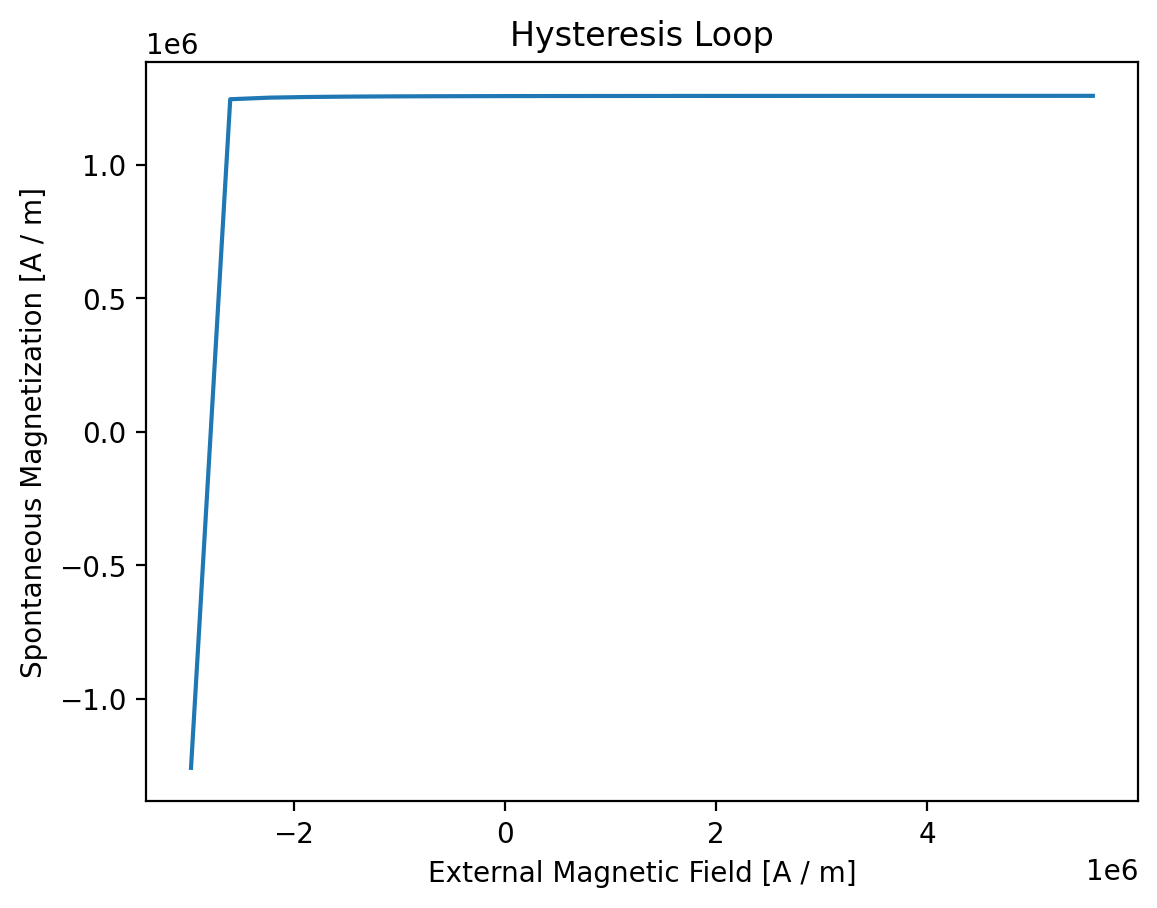

In [31]:
loop_results.plot(duplicate=False);

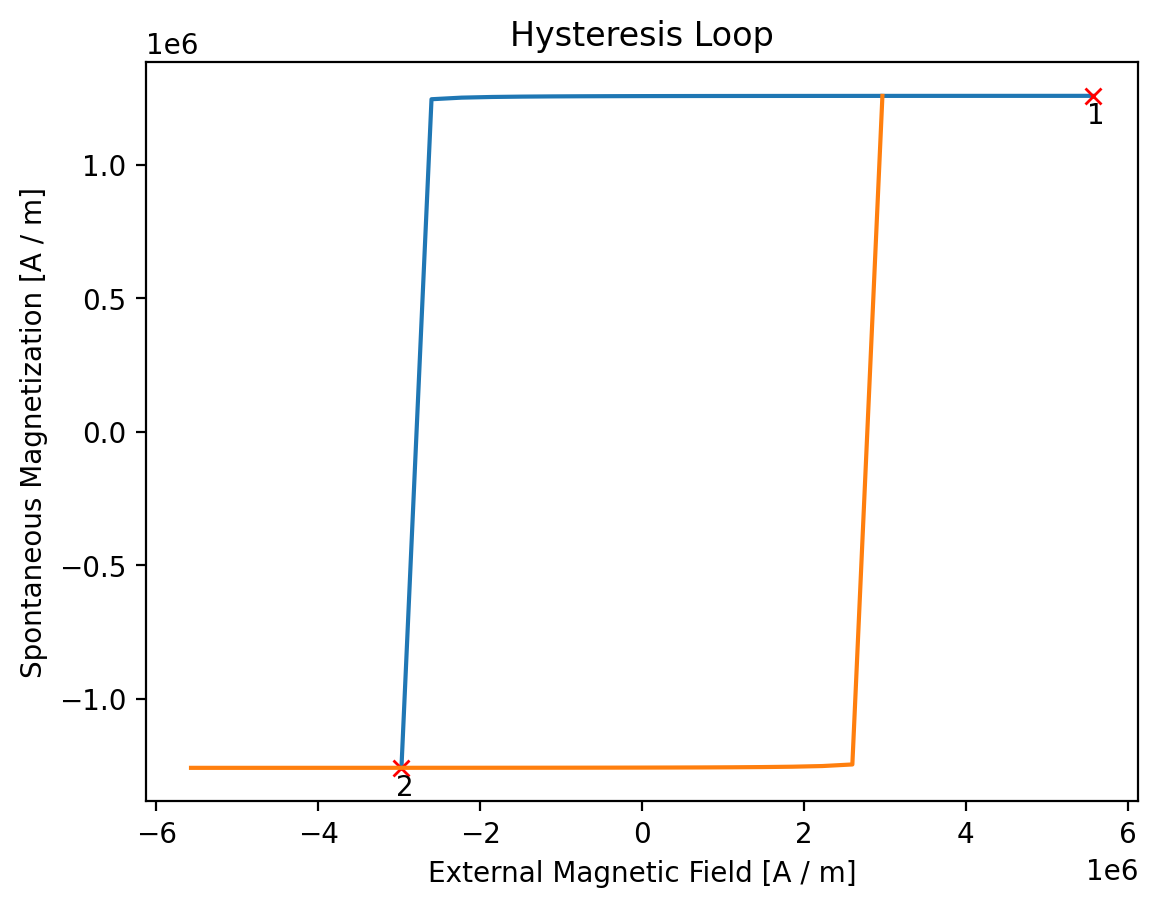

In [32]:
loop_results.plot(duplicate=True, configuration_marks=True);

In [33]:
loop_results.configurations

{1: PosixPath('/home/sam/repos/mammos/docs/source/examples/workflows/hystloop/hystloop_0001.vtu'),
 2: PosixPath('/home/sam/repos/mammos/docs/source/examples/workflows/hystloop/hystloop_0002.vtu')}

In [34]:
loop_results.plot_configuration(1, jupyter_backend="trame")

Widget(value='<iframe src="http://localhost:32935/index.html?ui=P_0x7f48de942950_0&reconnect=auto" class="pyvi…

We can extract the extrinsic properties with the `extrinsic_properties` function from the `mammos_analysis` package:

In [35]:
extrinsic_properties = mammos_analysis.hysteresis.extrinsic_properties(
    loop_results.H,
    loop_results.M,
    demagnetisation_coefficient=1/3,
)

In [36]:
extrinsic_properties.Hc

CoercivityHcExternal(value=2784283.1743903845, unit=A / m)

In [37]:
extrinsic_properties.Mr

Remanence(value=1258115.9927382383, unit=A / m)

In [38]:
extrinsic_properties.BHmax

MaximumEnergyProduct(value=218030.75811616005, unit=J / m3)

In [39]:
Mr = mammos_analysis.hysteresis.extract_remanent_magnetization(loop_results.H, loop_results.M)
Mr

Remanence(value=1258115.9927382383, unit=A / m)

In [40]:
Hc = mammos_analysis.hysteresis.extract_coercive_field(loop_results.H, loop_results.M)
Hc

CoercivityHcExternal(value=2784283.1743903845, unit=A / m)

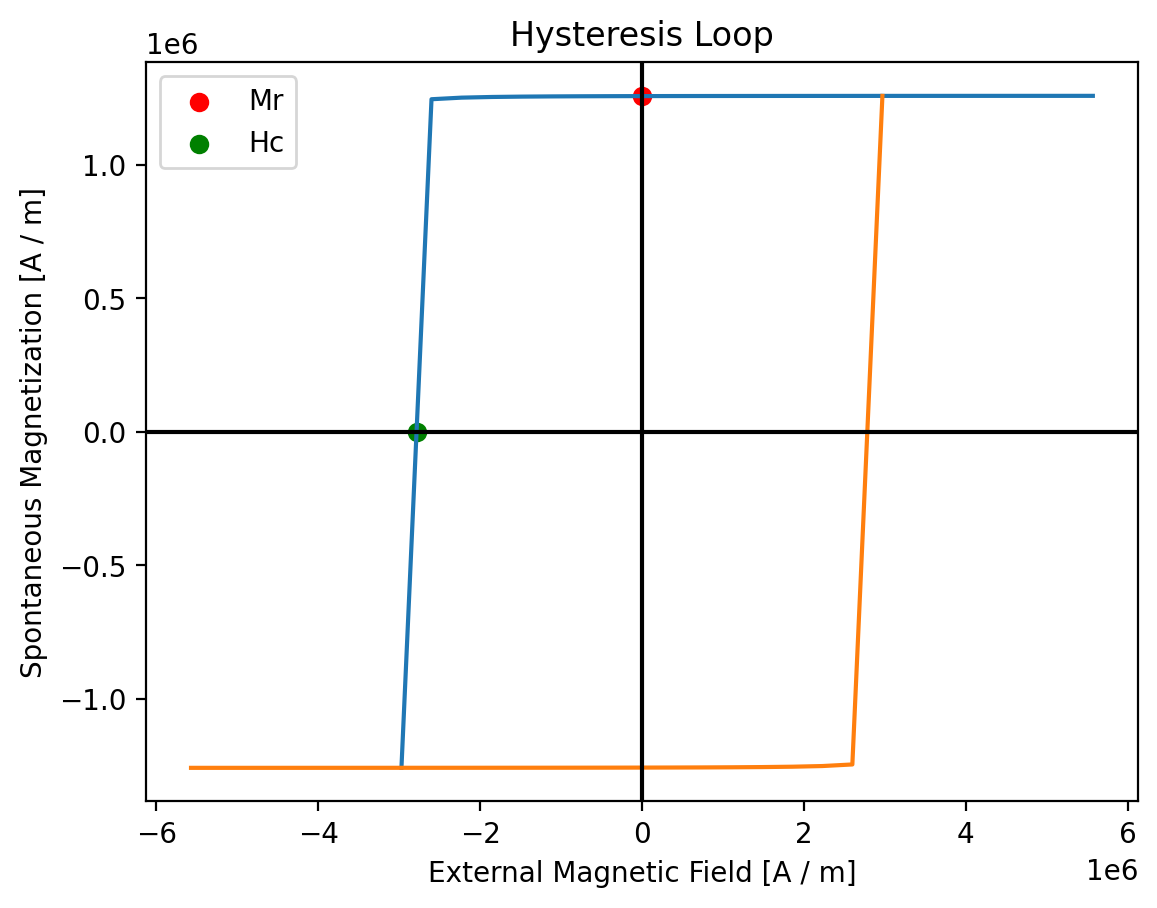

In [41]:
loop_results.plot()
plt.axhline(0, c="k")
plt.axvline(0, c="k")
plt.scatter(0, Mr.value, c="r", label="Mr")
plt.scatter(-Hc.value, 0, c="g", label="Hc")
plt.legend();

In [42]:
T = np.linspace(0, 700, 7)

simulations = []
for temperature in T:
    loop_results = mammos_mumag.hysteresis.run(
        mesh_filepath=mammos_mumag.mesh.CUBE_20_nm,
        Ms=kuzmin_result.Ms(temperature),
        A=kuzmin_result.A(temperature),
        K1=kuzmin_result.K1(temperature),
        hstart=(7*u.T).to(u.A / u.m),
        hfinal=(-10*u.T).to(u.A / u.m),
        hnsteps=30,
    )
    simulations.append(loop_results)

In [43]:
Hcs = []
for res in simulations:
    try:
        cf = mammos_analysis.hysteresis.extract_coercive_field(
            H=res.H, M=res.M
        ).value
    except ValueError:
        cf = 0
    Hcs.append(cf)

Text(0, 0.5, 'Coercive field [A / m]')

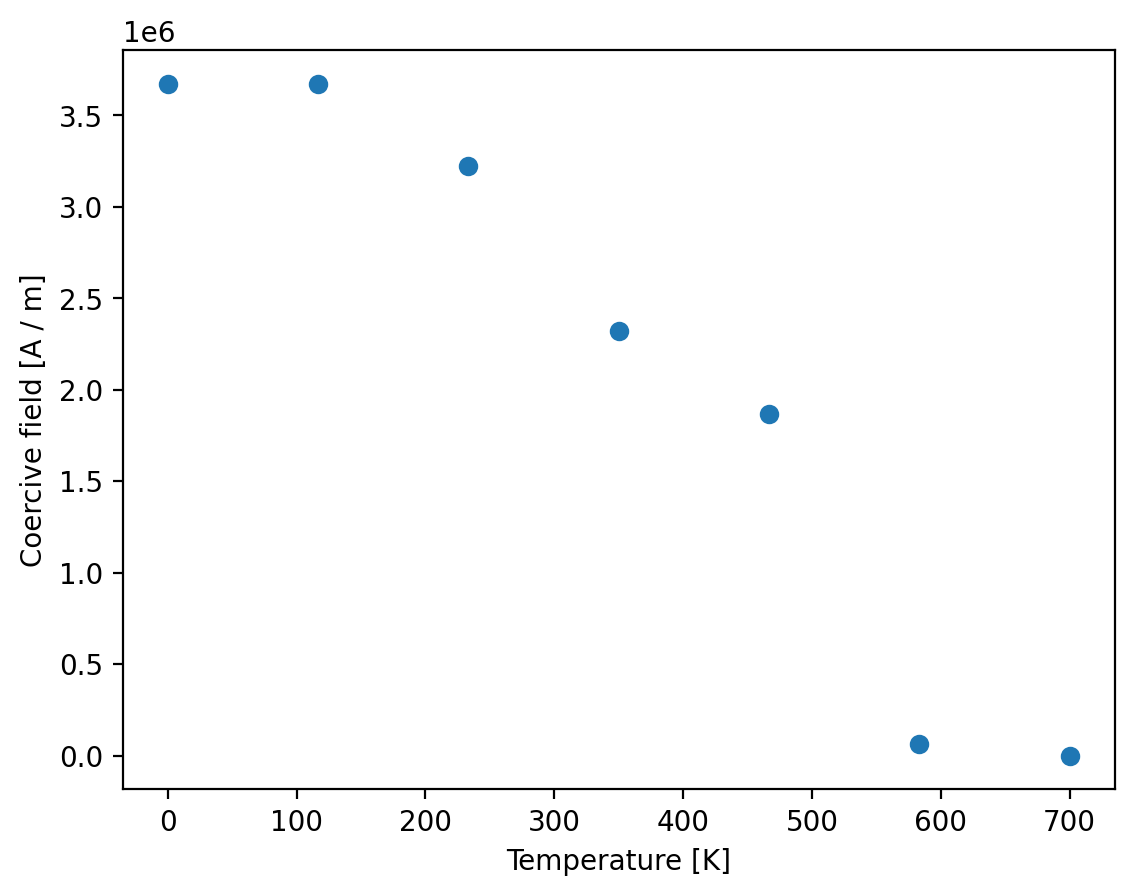

In [44]:
plt.scatter(T, Hcs)
plt.xlabel("Temperature [K]")
plt.ylabel("Coercive field [A / m]")

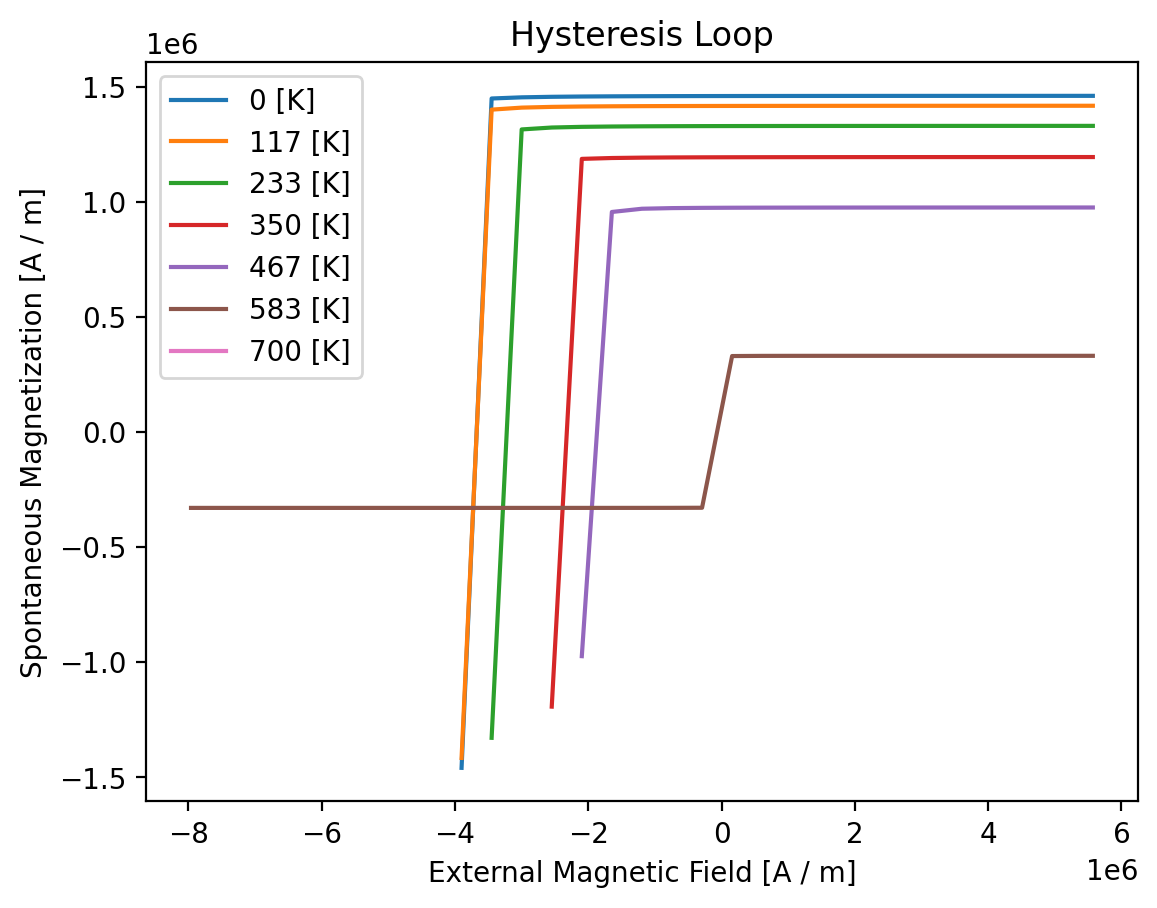

In [45]:
fix, ax = plt.subplots()
for temperature, sim in zip(T, simulations):
    sim.plot(ax=ax, duplicate=False, label=f"{temperature:.0f} [K]")